## Testing the construction of data loading code with Albumentations

In [1]:
import os
import cv2
import random

import numpy as np
import matplotlib.pyplot as plt

import albumentations as A

from albumentations.pytorch import ToTensorV2

In [2]:
# helper function for data visualisation
def visualize(**images):
    
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        
        # display in grayscle because our ISBI data is grayscale (autoscaling the image)
        plt.imshow(image, cmap='gray')
        
    plt.show()

### Build a segmentation dataset (based on the Pytorch Dataset class)

In [3]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [4]:
class SegmentationDataset(Dataset):      
    
    # set the initial parameters
    def __init__(self, root_dir, transform=None):
        
        self.ids  = os.listdir(root_dir + 'images/')
        self.imgs = [os.path.join(root_dir, 'images/', i) for i in self.ids]
        self.mask = [os.path.join(root_dir, 'masks/', i) for i in self.ids]
        
        self.transform = transform
                
    
    # get a single item from the data set
    def __getitem__(self, idx):
        
        # read image and mask data (both grayscale here)
        image = cv2.imread(self.imgs[idx], 0)
        masks = cv2.imread(self.mask[idx], 0)
        
        # store in our sample dictionary
        sample = {'image': image, 
                  'mask': masks}
        
        # apply any transforms
        if self.transform:
            new = self.transform(image=sample['image'], mask=sample['mask'])
            sample['image'] = new['image']
            sample['mask'] = new['mask']
            
        return sample
    
    
    # get the length of the data set
    def __len__(self):
        return len(self.ids)

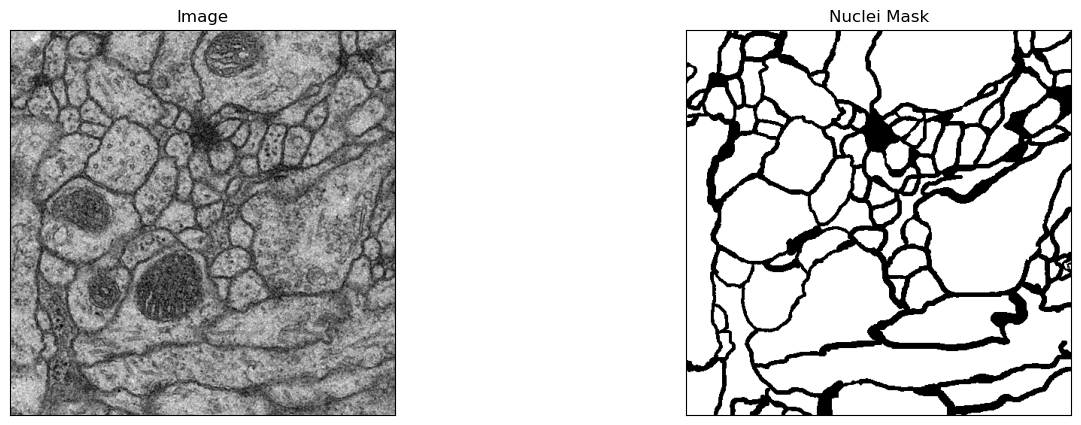

In [5]:
# look at a random example from the training data
dataset = SegmentationDataset('./data/isbi_segmentation_dataset/train/')
sample = dataset[4]
visualize(image=sample['image'], nuclei_mask=sample['mask'].squeeze())

Let's look at the raw data values to sanity check them ...

In [6]:
print("the mask contains the values {0}".format(np.unique(sample['mask'].squeeze())))
print("the mask has shape {0}".format(sample['mask'].shape, sample['image'].shape))

the mask contains the values [  0 255]
the mask has shape (512, 512)


### Create a data augmentation pipeline with Albumentations

There are a few "gotchas" here that I've discovered when going through the code.

1) ToTensorV2 from Albumentations doesn't rescale the data from 0 .. 1, which is particularly an issue for the mask. This means that, when we load the mask as grayscale using opencv, the values are either 0 or 255 (rather than 0 or 1. However, this may be desirable if we have multiple pixel labels in our image (e.g. each class is represented by a numbered pixel).

2) Normalize from Albumentations only rescales and normalizes the image (which is obviously intended - but caught me out as the image values were 0 .. 1 and the mask values were 0 .. 255!

So to overcome this, I wrote my own "to_tensor" method - however, this wont work for multiclass segmentation problems!

In [7]:
import torch

In [8]:
# my "to_tensor" method
def to_tensor(im, **kwargs):
    im = im / (255.0 if im.dtype == np.uint8 else 1)
    im = np.expand_dims(im, -1)
    im = np.moveaxis(im, -1, 0)
    tensor = torch.from_numpy(im.astype(np.float32))
    return tensor

In [9]:
training_augmentations = A.Compose([
        
    # mess with the image scales (random crops, rotations, etc.)
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0.25, shift_limit=0.1, p=1, border_mode=0),
    A.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
    A.RandomCrop(height=512, width=512, always_apply=True),
    
    A.ElasticTransform(p=1, alpha=50, sigma=100 * 0.05, alpha_affine=100 * 0.03),
    
    # probably should apply contrast adjustment to the image also ...
    
    #A.Normalize(mean=(0), std=(1)),
    #ToTensorV2(),
    A.Lambda(image=to_tensor, mask=to_tensor)
])

/tmp/ipykernel_26333/2391981119.py:9: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(p=1, alpha=50, sigma=100 * 0.05, alpha_affine=100 * 0.03),


In [10]:
test_augmentations = A.Compose([
    A.PadIfNeeded(512, 512),
    #A.Normalize(mean=(0), std=(1)),
    #ToTensorV2(),
    A.Lambda(image=to_tensor, mask=to_tensor)
])

### Apply augmentations and look at some of the results

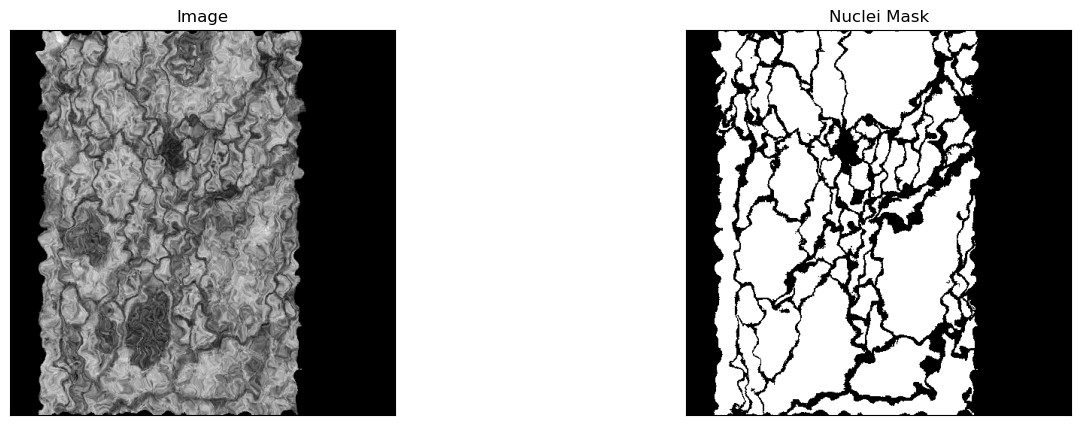

In [12]:
# look at a random example from the training data
dataset = SegmentationDataset('./data/isbi_segmentation_dataset/train/', transform=training_augmentations)
sample = dataset[4]
visualize(image=sample['image'].squeeze(), nuclei_mask=sample['mask'].squeeze())

In [13]:
print(sample['image'].shape)

torch.Size([1, 512, 512])


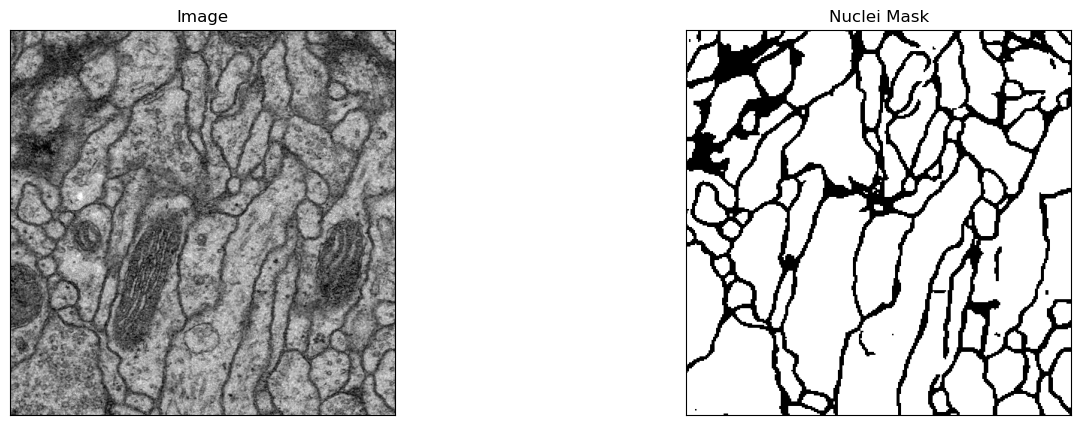

In [15]:
# look at a random example from the test data
dataset = SegmentationDataset('./data/isbi_segmentation_dataset/test/', transform=test_augmentations)
sample = dataset[4]
visualize(image=sample['image'].squeeze(), nuclei_mask=sample['mask'].squeeze())

In [16]:
print(sample['image'].shape)

torch.Size([1, 512, 512])


In [17]:
print("the image contains the values {0}".format(np.unique(sample['image'].squeeze())))
print("the mask contains the values {0}".format(np.unique(sample['mask'].squeeze())))

the image contains the values [0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313726
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.07450981 0.07843138 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196079 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941177 0.13333334 0.13725491
 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275 0.16078432
 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216 0.18431373
 0.1882353  0.19215687 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568628 0.21960784 0.22352941 0.22745098 0.23137255
 0.23529412 0.23921569 0.24313726 0.24705882 0.2509804  0.25490198
 0.25882354 0.2627451  0.26666668 0.27058825 0.27450982 0.2784314
 0.28235295 0.28627452 0.2901961  0.29411766 0.29803923 0.3019608
 0.30588236 0.30980393 0.3137255  0.31764707 0.32156864 0.3254902
 0.32941177 0.33333334 0.3372549  0